In [213]:
import numpy as np 
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [168]:
########Read the data
root="C:/Users/STEVE/Desktop/data/zillo data/"
prop=pd.read_csv(root+"properties_2016.csv")
train=pd.read_csv(root+"train_2016_v2.csv")
###########merge two table to have both input and output data for training
df=train.merge(prop, left_on='parcelid', right_on='parcelid', how='inner')

C:\Users\STEVE\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [209]:
###only extract data for October 2016
df1=df[pd.to_datetime(df.transactiondate, yearfirst=True).dt.month==10]
###### compute fraction of nulls for each column
null_fraction=df1.isnull().sum()/df1.parcelid.count()
########### find the list of columns wheer at least 90% of data are given. these will columns used for training 
col_list=null_fraction[null_fraction<0.1].index.tolist()
########### find the index of training columns 
col_index=[]
for i in range(0,len(df1.columns.tolist())):
    if  df1.columns[i] not in col_list:
        col_index.append(i)
#### drop columns that are not in the trainig list ( i.e. col_index)
df1.drop(df1.columns[col_index], axis=1, inplace=True)
### drop all the remaining null values
df1=df1.dropna()
#####sepaarte the value of resposne
y=df1['logerror']
##### drop other columns that are not used for training 
df1=df1.drop(['parcelid', 'logerror', 'transactiondate','propertycountylandusecode'], axis=1)


C:\Users\STEVE\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [197]:
####### Normalize variables
X_scale=scale(df1.as_matrix())
####### transform variables
pca = PCA()
X_transform = pca.fit_transform(X_scale)

C:\Users\STEVE\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [198]:
####split variables: 25% for test and the rest for training 
X_train, X_test, y_train, y_test = train_test_split(X_transform, y.ravel(),
                                                        test_size=0.25, random_state=133)


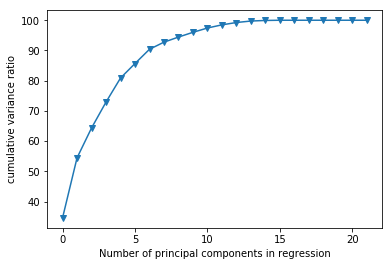

In [214]:

####### cumulative percent of variance explained. this shows that about 90% is explained by first 7 variables
var_ratio=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
#components=np.arange(1, len(df1.columns))
plt.plot(var_ratio, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('cumulative variance ratio')
plt.show()

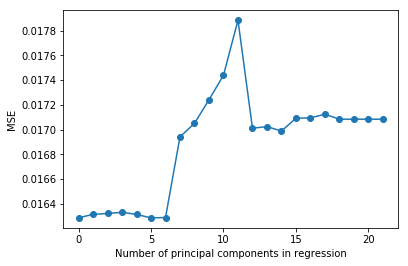

based on this char the first 6 compenents will be included


In [212]:
#######20 fold cross validation to detremine the number of components to be included
n = len(X_train)
folds = KFold(n_splits=20, shuffle=True, random_state=1)
regr = LinearRegression()
######list to store Mean Squre Error
mse = []
score = -1*cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=folds, scoring='neg_mean_squared_error').mean()    
mse.append(score)
for i in np.arange(1, len(df1.columns)):
    score = -1*cross_val_score(regr, X_train[:,:i], y_train.ravel(), cv=folds, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(mse, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.show()
print("based on this char the first 6 compenents will be included")

In [208]:
###########implement the model on test data. This could be useful if I wanted to compare the model with other 
#### models such as KNN or gradient boosted tree. but I ran out of time.
regr.fit(X_train[:,:7], y_train)
pred = regr.predict(X_test[:,:7])
mean_squared_error(y_test, pred)

0.013919737862222524